# Índice

#### 1. [Introdução](#1)
#### 2. [Inicialização e funções auxiliares](#2)
#### 3. [SVM](#3)
#### 4. [Parâmetros C e gamma](#4)
#### 5. [Reduzindo o tempo de treino](#5)
#### 6. [Conclusão](#6)

## 1. Introdução<a name="1"></a>

Vamos continuar a trabalhar com os dados de cancelamentos de agendamentos de estadias em dois hotéis de uma empresa em Portugal.

Fizemos anteriormente a análise inicial dos dados e um primeiro modelo utilizando árvores de decisão, que otimizamos até atingirmos as seguintes estatísticas:

- Acurácia na base de treino: 81.53%
    - Modelo previu cancelado, mas é não cancelado: 17.47%
    - Modelo previu não cancelado, e é não cancelado: 82.53%
    - Modelo previu não cancelado, mas é cancelado: 20.17%
    - Modelo previu cancelado, e é cancelado: 79.83%
- Acurácia na base de teste: 81.28%
    - Modelo previu cancelado, mas é não cancelado: 17.21%
    - Modelo previu não cancelado, e é não cancelado: 82.79%
    - Modelo previu não cancelado, mas é cancelado: 21.27%
    - Modelo previu cancelado, e é cancelado: 78.73%

Também utilizamos a técnica de PCA a fim de reduzir as variáveis e melhorar nossa acurácia, mas no fim obtivemos resultados piores do que os da nossa análise inicial.

Neste caderno vamos continuar trabalhando com esses dados, mas buscando melhorar o modelo utilizando técnicas de SVM.

- O resumo do trabalho pode ser acessado aqui: [resumo do trabalho](https://github.com/luckssm/hotel-booking/blob/main/relatorio_hotel_booking.pdf)
- O caderno anterior (PCA) pode ser acessado aqui: [caderno PCA](https://github.com/luckssm/hotel-booking/blob/main/hotel_booking_PCA.ipynb)
- O próximo caderno (Random Forest) pode ser acessado aqui: [caderno Random Forest](https://github.com/luckssm/hotel-booking/blob/main/hotel_booking_random_forest.ipynb)
- A base original pode ser acessada aqui: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

Vamos continuar utilizando a base trabalhada anteriormente, que possui os campos: 

| Variável | Tipo | Descrição |
| -------- | ---- | --------- |
| hotel                          |  object  | Hotel (H1 = Resort Hotel or H2 = City Hotel) |
| is_canceled                    |  int64   | Value indicating if the booking was canceled (1) or not (0) |
| lead_time                      |  int64   | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year              |  int64   | Year of arrival date |
| arrival_date_month             |  object  | Month of arrival date (1 - January, 2 - February...) |
| arrival_date_week_number       |  int64   | Week number of year for arrival date |
| arrival_date_day_of_month      |  int64   | Day of arrival date |
| stays_in_weekend_nights        |  int64   | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights           |  int64   | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults                         |  int64   | Number of adults |
| children                       |  float64 | Number of children |
| babies                         |  int64   | Number of babies |
| meal                           |  object  | Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| market_segment                 |  object  | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel           |  object  | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest              |  int64   | Value indicating if the booking name was from a repeated guest (1) or not (0) |
| previous_cancellations         |  int64   | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled |  int64   | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type             |  object  | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| assigned_room_type             |  object  | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons. |
| booking_changes                |  int64   | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type                   |  object  | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| agent                          |  float64 | ID of the travel agency that made the booking  |
| company                        |  float64 | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
| days_in_waiting_list           |  int64   | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type                  |  object  | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking |
| adr                            |  float64 | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces    |  int64   | Number of car parking spaces required by the customer |
| total_of_special_requests      |  int64   | Number of special requests made by the customer (e.g. twin bed or high floor) |

## 2. Inicialização e funções auxiliares<a name="2"></a> 

Importações:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [2]:
main = pd.read_csv('hotel_bookings_cleaned.csv')
main.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,3,3,3,-1.0,-1.0,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,3,3,4,-1.0,-1.0,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,1,3,0,-1.0,-1.0,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,1,1,0,304.0,-1.0,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,1,1,0,240.0,-1.0,0,Transient,98.0,0,1


Vamos obter as variáveis dummies:

In [3]:
main_dummies = pd.get_dummies(main)
main_dummies.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,7,27,1,0,0,2,0.0,...,False,False,True,False,False,False,False,False,True,False
1,0,737,2015,7,27,1,0,0,2,0.0,...,False,False,True,False,False,False,False,False,True,False
2,0,7,2015,7,27,1,0,1,1,0.0,...,False,False,True,False,False,False,False,False,True,False
3,0,13,2015,7,27,1,0,1,1,0.0,...,False,True,False,False,False,False,False,False,True,False
4,0,14,2015,7,27,1,0,2,2,0.0,...,False,False,False,False,True,False,False,False,True,False


E dividir nossa base em teste, treino e validação:

In [4]:
X = main_dummies.drop('is_canceled', axis=1)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=7412395)

Vamos primeiro criar uma função auxiliar para calcular a acurácia dos nossos modelos:

In [5]:
# Plots confusion matrix
def plot_confusion_matrix(cm):
    MatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                           display_labels=['Não cancelado', 'Cancelado']
                                          )
    MatrixDisplay.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()

# Calculates the confusion matrix
def calculate_confusion_matrix(y_true, y_pred, type, show_acc=False, plot_matrix=False):
    cm = confusion_matrix(y_true, y_pred)
    tab = pd.crosstab(index = y_true, columns = y_pred)
    
    # Predicted canceled, but is not canceled
    false_positive_acc = (tab.iloc[0, 1] / (tab.iloc[0, 1] + tab.iloc[0, 0])) * 100
    
    # Predicted not canceled, and is not canceled
    true_negative_acc = (tab.iloc[0, 0] / (tab.iloc[0, 1] + tab.iloc[0, 0])) * 100
    
    # Predicted not canceled, and is canceled
    false_negative_acc = (tab.iloc[1, 0] / (tab.iloc[1, 1] + tab.iloc[1, 0])) * 100
    
    # Predicted canceled, and is canceled
    true_positive_acc = (tab.iloc[1, 1] / (tab.iloc[1, 1] + tab.iloc[1, 0])) * 100

    if show_acc:
        print(f'Acurácias de {type}:')
        print(f'Modelo previu cancelado, mas é não cancelado: {false_positive_acc:.2f}%')
        print(f'Modelo previu não cancelado, e é não cancelado: {true_negative_acc:.2f}%')
        print(f'Modelo previu não cancelado, mas é cancelado: {false_negative_acc:.2f}%')
        print(f'Modelo previu cancelado, e é cancelado: {true_positive_acc:.2f}%')
    
    if plot_matrix:
        plot_confusion_matrix(cm)
        
    return [true_negative_acc, true_positive_acc]
        

# Calculates accuracy of model based on train and test bases and shows confusion matrix if wanted
def calculate_model_acc_score(model, x_train, y_train, x_test, y_test, show_confusion_matrix=False, show_acc=False):
    y_pred_train = model.predict(x_train)
    acc_train = accuracy_score(y_train, y_pred_train)*100
    
    y_pred_test = model.predict(x_test)
    acc_test = accuracy_score(y_test, y_pred_test)*100

    if show_acc:
        print('Acurácia na base de treino: {0:.2f}%'.format(acc_train)) 
        print('Acurácia na base de teste: {0:.2f}%'.format(acc_test))
        print('\n')
    
    accuracies = [acc_train, acc_test]
    train_acc_matrix = calculate_confusion_matrix(y_train, y_pred_train, type='treino', show_acc=show_acc, plot_matrix=show_confusion_matrix)
    test_acc_matrix = calculate_confusion_matrix(y_test, y_pred_test, type='teste', show_acc=show_acc, plot_matrix=show_confusion_matrix)
    accuracies = accuracies + train_acc_matrix + test_acc_matrix

    return accuracies
    

## 3. SVM<a name="3"></a> 

Agora vamos treinar um SVM com o método SVC do scikit-learn, desenvolvido para classificação e aplicar na nossa base de validação:

In [7]:
%%time
clf = svm.SVC(random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 5min 12s, sys: 109 ms, total: 5min 12s
Wall time: 5min 16s


SVC(random_state=7412395)

Acurácia na base de treino: 66.54%
Acurácia na base de teste: 66.36%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 4.94%
Modelo previu não cancelado, e é não cancelado: 95.06%
Modelo previu não cancelado, mas é cancelado: 82.18%
Modelo previu cancelado, e é cancelado: 17.82%


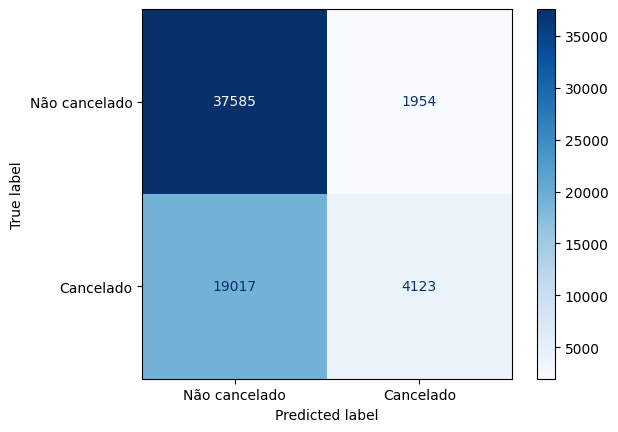

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 5.15%
Modelo previu não cancelado, e é não cancelado: 94.85%
Modelo previu não cancelado, mas é cancelado: 81.71%
Modelo previu cancelado, e é cancelado: 18.29%


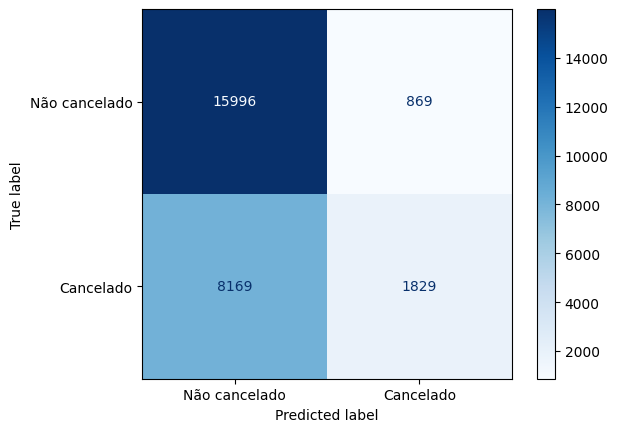

[66.54222307311859,
 66.35520976808249,
 95.05804395659982,
 17.817631806395852,
 94.84731692855026,
 18.293658731746348]

In [8]:
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

Temos um resultado bem assustador. O número de falsos negativos é muito elevado, perto de 82%. Isso indica que nosso modelo ficou muito bom em prever não cancelamentos (quase 95% de acurácia), porém ficou muito ruim em prever cancelamentos (que é a nossa métrica mais desejada).

Poderíamos concluir que utilizar SVM não é o ideal para esse problema, mas nada nos leva a crer que esse é o caso, já que temos uma base com um número razoável de colunas, porém com muitas amostras, o que deveria funcionar bem para o SVM;

No entanto, temos um problema que é prejudicial para o SVM: temos dados desbalanceados. Como já vimos em outros estudos, esses dados possuem cerca de 38% de cancelamentos contra 62% de não cancelamentos.

Considerando isso, vamos utilizar o parâmetro `class_weight` do SVC e verificar os novos resultados:

In [9]:
%%time
clf = svm.SVC(class_weight='balanced', random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 7min 39s, sys: 45.8 ms, total: 7min 39s
Wall time: 7min 45s


SVC(class_weight='balanced', random_state=7412395)

Acurácia na base de treino: 63.91%
Acurácia na base de teste: 64.77%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 30.08%
Modelo previu não cancelado, e é não cancelado: 69.92%
Modelo previu não cancelado, mas é cancelado: 46.34%
Modelo previu cancelado, e é cancelado: 53.66%


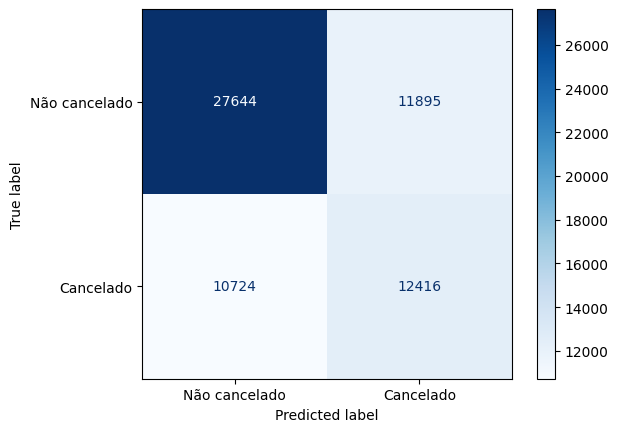

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 29.66%
Modelo previu não cancelado, e é não cancelado: 70.34%
Modelo previu não cancelado, mas é cancelado: 44.61%
Modelo previu cancelado, e é cancelado: 55.39%


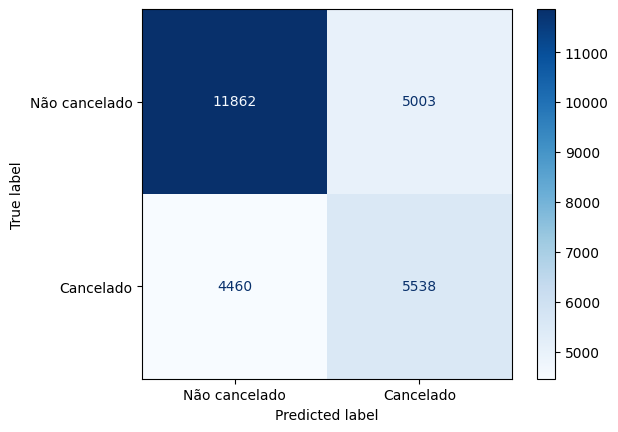

CPU times: user 5min 29s, sys: 12.7 ms, total: 5min 29s
Wall time: 5min 32s


[63.912953301743805,
 64.77310799240591,
 69.91577935709047,
 53.65600691443389,
 70.33501334123925,
 55.391078215643134]

In [10]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

Tivemos uma melhora significativa na previsão de cancelamentos, em detrimento de uma piora na acurácia dos não cancelamentos. Estamos progredindo.

Existe um outro problema com SVMs, relacionado à padronização dos dados. Esse tipo de modelo é muito sensível à escala dos dados, então dados não padronizados podem acarretar em problemas na modelagem. Nossos dados se encaixam nesse problema, pois temos variáveis binárias (flags), números inteiros pequenos, floats, etc. 

Vamos padronizar nossos dados e verificar os novos resultados:

In [11]:
scaler = StandardScaler()

X = main_dummies.drop('is_canceled', axis=1)
scaler.fit(X)
X = scaler.transform(X)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=7412395)

In [12]:
%%time
clf = svm.SVC(class_weight='balanced', random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 5min 30s, sys: 19.7 ms, total: 5min 30s
Wall time: 5min 34s


SVC(class_weight='balanced', random_state=7412395)

Acurácia na base de treino: 81.78%
Acurácia na base de teste: 81.40%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 15.40%
Modelo previu não cancelado, e é não cancelado: 84.60%
Modelo previu não cancelado, mas é cancelado: 23.04%
Modelo previu cancelado, e é cancelado: 76.96%


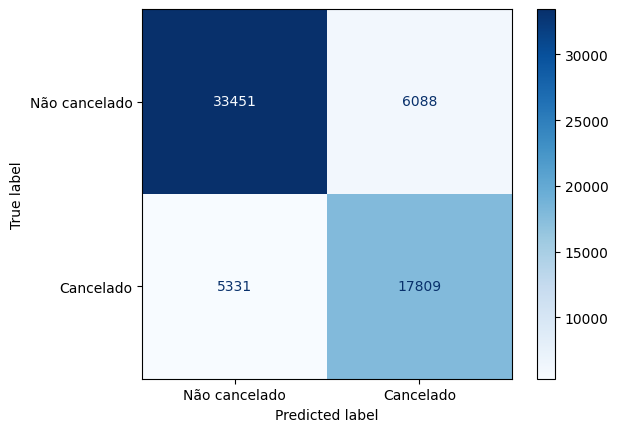

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.68%
Modelo previu não cancelado, e é não cancelado: 84.32%
Modelo previu não cancelado, mas é cancelado: 23.52%
Modelo previu cancelado, e é cancelado: 76.48%


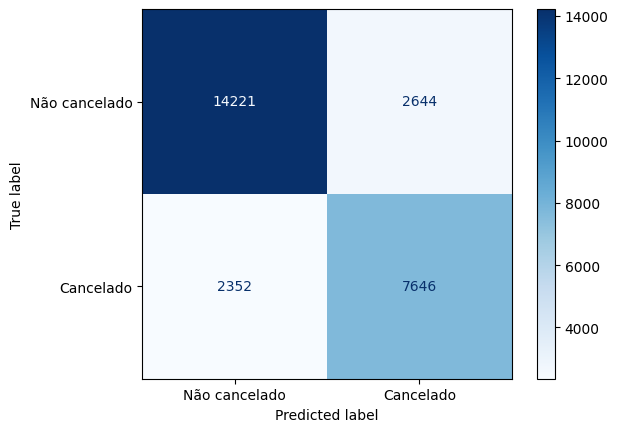

CPU times: user 3min 22s, sys: 8.86 ms, total: 3min 22s
Wall time: 3min 24s


[81.78177699069865,
 81.40192830287012,
 84.60254432332633,
 76.961970613656,
 84.32256151793655,
 76.4752950590118]

In [13]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

Tivemos uma melhora significativa nos nossos resultados! Temos uma acurácia na base de validação de 81,40%, bem próxima à da base de treino (81,78%), o que indica não haver overfitting. Além disso, nossa acurácia de não cancelados está em 84,32% e a de cancelamentos em 76,48%. 

Ou seja, melhoramos a acurácia de não cancelamento com relação ao melhor modelo encontrado até agora e estamos com uma acurácia de cancelamento bem próxima à melhor até o momento.

Apesar do tempo de processamento para criação do modelo, os passos foram bem simples, o que é um ponto positivo para essa técnica até agora.

## 4. Parâmetros C e gamma<a name="4"></a>

Temos agora uma outra possível melhoria: os parâmetros C e gamma. Vamos começar pelo C:

In [14]:
%%time
clf = svm.SVC(class_weight='balanced', C=10, random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 7min 1s, sys: 114 ms, total: 7min 1s
Wall time: 7min 6s


SVC(C=10, class_weight='balanced', random_state=7412395)

Acurácia na base de treino: 84.06%
Acurácia na base de teste: 82.55%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 14.63%
Modelo previu não cancelado, e é não cancelado: 85.37%
Modelo previu não cancelado, mas é cancelado: 18.17%
Modelo previu cancelado, e é cancelado: 81.83%


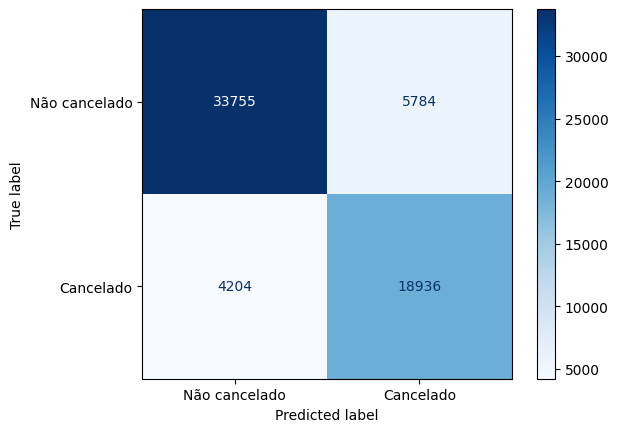

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.72%
Modelo previu não cancelado, e é não cancelado: 84.28%
Modelo previu não cancelado, mas é cancelado: 20.37%
Modelo previu cancelado, e é cancelado: 79.63%


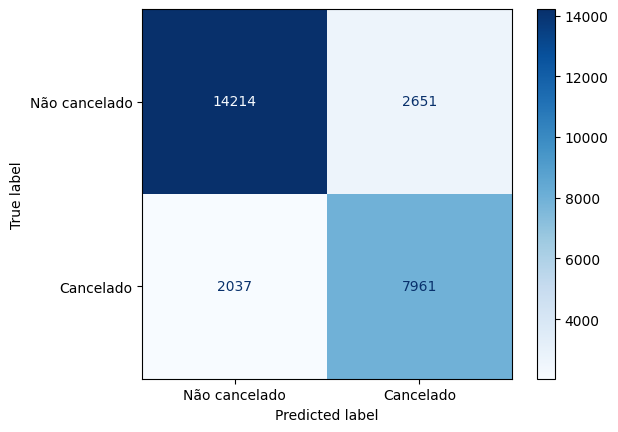

CPU times: user 3min 6s, sys: 14.8 ms, total: 3min 6s
Wall time: 3min 8s


[84.06483830309992,
 82.54848676618397,
 85.37140544778573,
 81.83232497839239,
 84.2810554402609,
 79.625925185037]

In [15]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

In [16]:
%%time
clf = svm.SVC(class_weight='balanced', C=100, random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 20min 51s, sys: 109 ms, total: 20min 51s
Wall time: 21min 5s


SVC(C=100, class_weight='balanced', random_state=7412395)

Acurácia na base de treino: 86.84%
Acurácia na base de teste: 82.58%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 12.97%
Modelo previu não cancelado, e é não cancelado: 87.03%
Modelo previu não cancelado, mas é cancelado: 13.50%
Modelo previu cancelado, e é cancelado: 86.50%


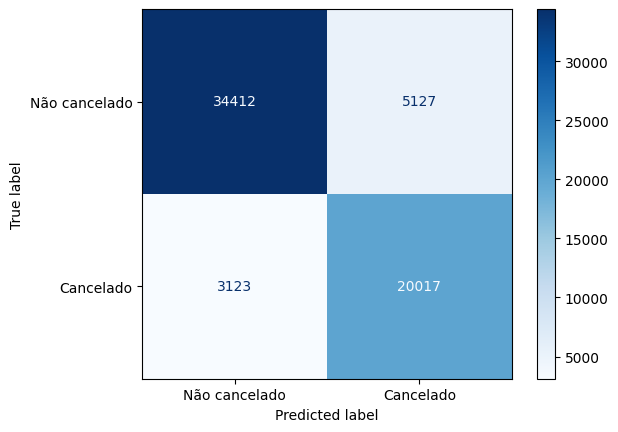

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.32%
Modelo previu não cancelado, e é não cancelado: 83.68%
Modelo previu não cancelado, mas é cancelado: 19.27%
Modelo previu cancelado, e é cancelado: 80.73%


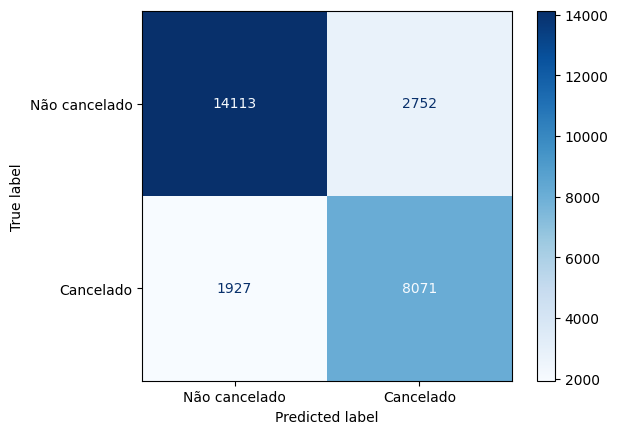

CPU times: user 2min 54s, sys: 10.7 ms, total: 2min 54s
Wall time: 2min 56s


[86.83769683626095,
 82.58199009790418,
 87.03305597005489,
 86.5038893690579,
 83.6821820337978,
 80.72614522904581]

In [17]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

In [19]:
best_model = clf

Obtivemos nosso melhor modelo até agora, tanto na acurácia geral quanto na previsão de cancelamentos! No entanto, fizemos o teste por enquanto na base de validação. Vamos executar em breve na base de testes para verificar se este é o melhor modelo mesmo.

Após guardar esse modelo como o melhor, vamos começar a mexer no parâmetro `gamma`:

In [20]:
%%time
clf = svm.SVC(class_weight='balanced', C=100, gamma=0.1, random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 53min 11s, sys: 212 ms, total: 53min 11s
Wall time: 53min 48s


SVC(C=100, class_weight='balanced', gamma=0.1, random_state=7412395)

Acurácia na base de treino: 93.71%
Acurácia na base de teste: 82.39%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 7.15%
Modelo previu não cancelado, e é não cancelado: 92.85%
Modelo previu não cancelado, mas é cancelado: 4.82%
Modelo previu cancelado, e é cancelado: 95.18%


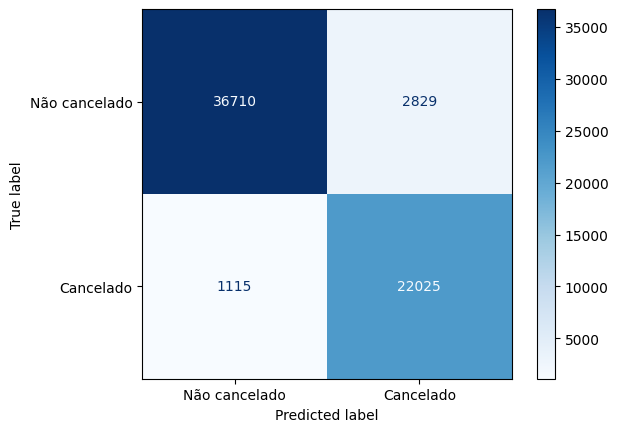

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.01%
Modelo previu não cancelado, e é não cancelado: 83.99%
Modelo previu não cancelado, mas é cancelado: 20.31%
Modelo previu cancelado, e é cancelado: 79.69%


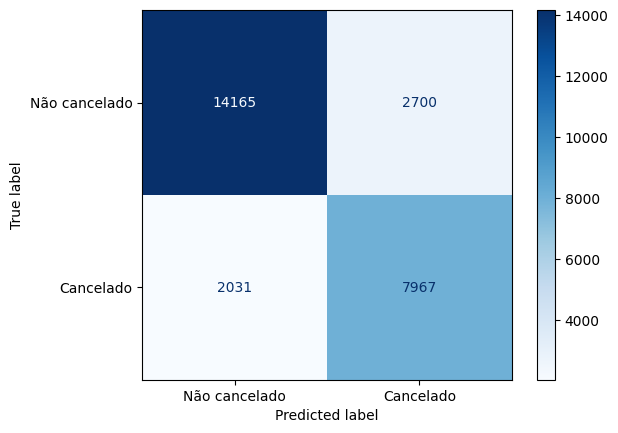

CPU times: user 2min 51s, sys: 7.89 ms, total: 2min 51s
Wall time: 2min 53s


[93.70762137238947,
 82.38841529240963,
 92.84503907534332,
 95.18150388936905,
 83.99051289653127,
 79.68593718743749]

In [21]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_validation, y_validation, show_confusion_matrix=True, show_acc=True)

Além do tempo muito maior para treinar o modelo, tivemos uma piora na acurácia de cancelamentos. 

Vamos prosseguir e testar nosso melhor modelo até o momento em nossa base de testes:

Acurácia na base de treino: 86.84%
Acurácia na base de teste: 82.71%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 12.97%
Modelo previu não cancelado, e é não cancelado: 87.03%
Modelo previu não cancelado, mas é cancelado: 13.50%
Modelo previu cancelado, e é cancelado: 86.50%


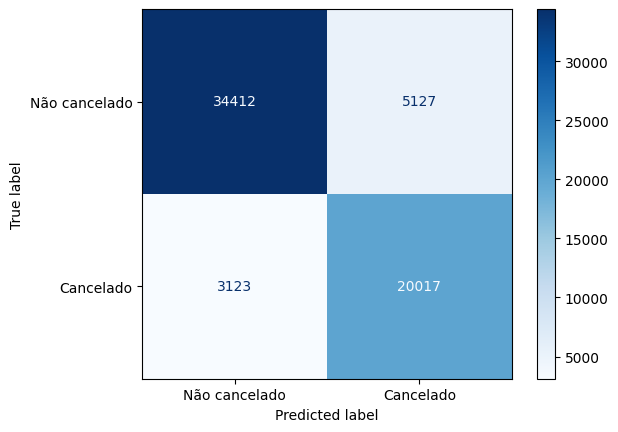

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.92%
Modelo previu não cancelado, e é não cancelado: 84.08%
Modelo previu não cancelado, mas é cancelado: 19.62%
Modelo previu cancelado, e é cancelado: 80.38%


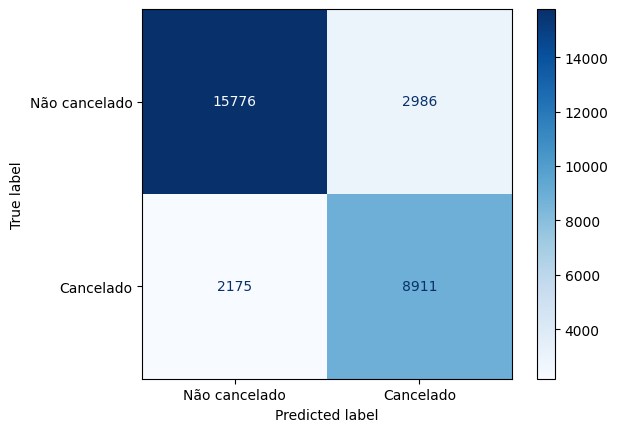

CPU times: user 3min 1s, sys: 24.6 ms, total: 3min 1s
Wall time: 3min 3s


[86.83769683626095,
 82.70905923344948,
 87.03305597005489,
 86.5038893690579,
 84.08485236115553,
 80.38066029226052]

In [22]:
%%time
calculate_model_acc_score(best_model, x_train, y_train, x_test, y_test, show_confusion_matrix=True, show_acc=True)

Realmente tivemos a melhor acurácia até aqui, com acurácias (em parênteses as acurácias do nosso antigo melhor modelo):
- Geral: 82,71% (81.28%);
- Não cancelamentos: 84.08% (82.79%);
- Cancelamentos: 80.38% (78.73%);

Aqui começamos a progredir! No entanto, temos um problema no SVM: o tempo de treino. 

## 5. Reduzindo o tempo de treino<a name="5"></a>

Pesquisando um pouco mais sobre o funcionamento do modelo, vemos que a complexidade do `svm.SVC()` utilizado é: 

*O($n$ funcionalidades X $n$ amostras²)*

Podendo chegar a *($n$ amostras)³*.

Por isso provavelmente a demora tão grande em treinar os modelos. Vamos tentar contornar esse problema, criando uma amostra de treino de apenas 10%, sendo que antes tínhamos esse número em 70%:

In [23]:
scaler = StandardScaler()

X = main_dummies.drop('is_canceled', axis=1)
scaler.fit(X)
X = scaler.transform(X)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.9, random_state=7412395)

In [24]:
%%time
clf = svm.SVC(class_weight='balanced', C=100, random_state=7412395)
clf.fit(x_train, y_train)

CPU times: user 4.47 s, sys: 1.68 ms, total: 4.48 s
Wall time: 4.51 s


SVC(C=100, class_weight='balanced', random_state=7412395)

Acurácia na base de treino: 90.74%
Acurácia na base de teste: 79.29%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 9.96%
Modelo previu não cancelado, e é não cancelado: 90.04%
Modelo previu não cancelado, mas é cancelado: 8.04%
Modelo previu cancelado, e é cancelado: 91.96%


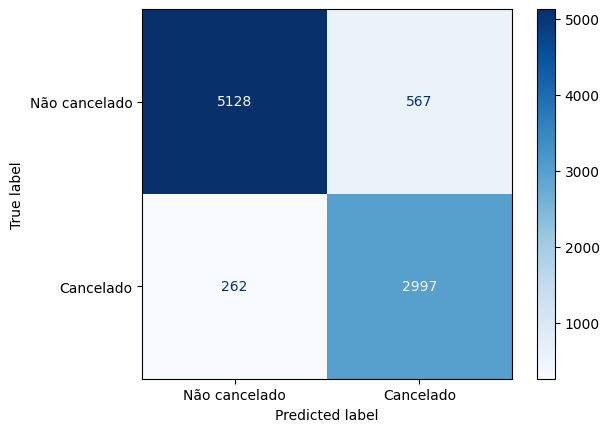

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 18.94%
Modelo previu não cancelado, e é não cancelado: 81.06%
Modelo previu não cancelado, mas é cancelado: 23.71%
Modelo previu cancelado, e é cancelado: 76.29%


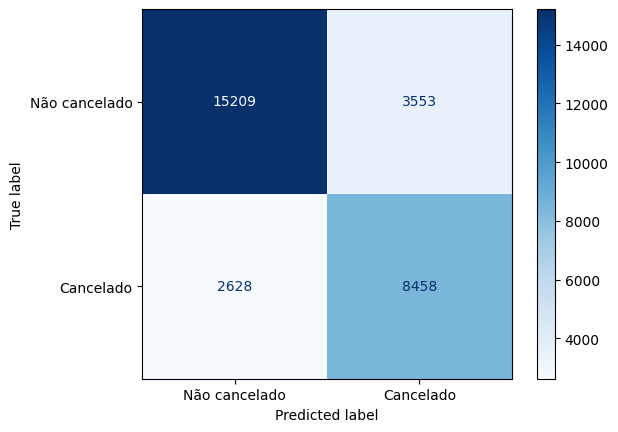

CPU times: user 11.5 s, sys: 75.8 ms, total: 11.5 s
Wall time: 11.6 s


[90.74156801429528,
 79.29174484052533,
 90.04389815627744,
 91.96072414851182,
 81.06278648331734,
 76.29442540140718]

In [25]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_test, y_test, show_confusion_matrix=True, show_acc=True)

Realmente, agora obtivemos um treinamento significativamente mais rápido, embora esteja com um indicativo de overfitting. Vamos aumentar a base de treino para 20%:

In [26]:
scaler = StandardScaler()

X = main_dummies.drop('is_canceled', axis=1)
scaler.fit(X)
X = scaler.transform(X)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.8, random_state=7412395)

In [27]:
%%time
clf = svm.SVC(class_weight='balanced', C=100)
clf.fit(x_train, y_train)

CPU times: user 45.1 s, sys: 16.5 ms, total: 45.1 s
Wall time: 45.6 s


SVC(C=100, class_weight='balanced')

Acurácia na base de treino: 89.00%
Acurácia na base de teste: 80.68%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 11.36%
Modelo previu não cancelado, e é não cancelado: 88.64%
Modelo previu não cancelado, mas é cancelado: 10.39%
Modelo previu cancelado, e é cancelado: 89.61%


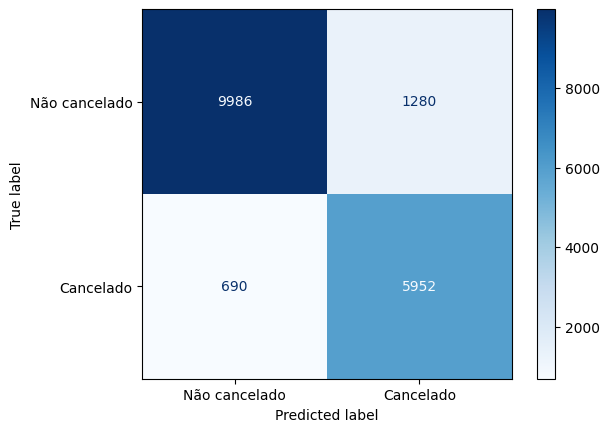

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 17.66%
Modelo previu não cancelado, e é não cancelado: 82.34%
Modelo previu não cancelado, mas é cancelado: 22.13%
Modelo previu cancelado, e é cancelado: 77.87%


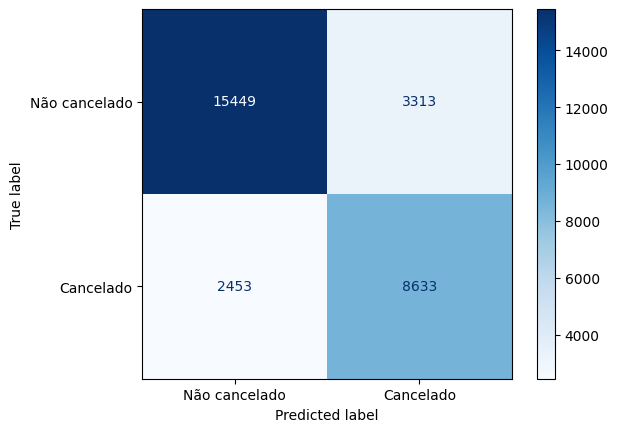

CPU times: user 27.4 s, sys: 3.95 ms, total: 27.4 s
Wall time: 27.5 s


[88.99932990842082,
 80.68212275529348,
 88.63838096928812,
 89.61156278229448,
 82.34196780727001,
 77.87299296409887]

In [28]:
%%time
calculate_model_acc_score(clf, x_train, y_train, x_test, y_test, show_confusion_matrix=True, show_acc=True)

O tempo aumentou um pouco, porém diminuímos a acurácia da base de treino e melhoramos da de testes, o que é positivo para evitar overfitting.

Agora que temos um tempo mais razoável para trabalhar, vamos buscar otimizar nossos parâmetros com a busca por grid, mas vamos voltar com os 10% de treino, para agilizar o processo:

In [29]:
%%time
scaler = StandardScaler()

X = main_dummies.drop('is_canceled', axis=1)
scaler.fit(X)
X = scaler.transform(X)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.9, random_state=7412395)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['auto', 'scale', 0.01, 0.1, 1]
}
clf = svm.SVC(class_weight='balanced', random_state=7412395)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Melhores parâmetros: {best_params}")
print(f"Melhor pontuação de treino: {best_score}")

test_score = grid_search.best_estimator_.score(x_test, y_test)
print(f'Acurácia no conjunto de teste: {test_score}')

Melhores parâmetros: {'C': 1, 'gamma': 0.1}
Melhor pontuação de treino: 0.7924951261584147
Acurácia no conjunto de teste: 0.8013937282229965
CPU times: user 16.1 s, sys: 416 ms, total: 16.5 s
Wall time: 2min 31s


Acurácia na base de treino: 87.67%
Acurácia na base de teste: 80.14%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 12.43%
Modelo previu não cancelado, e é não cancelado: 87.57%
Modelo previu não cancelado, mas é cancelado: 12.15%
Modelo previu cancelado, e é cancelado: 87.85%


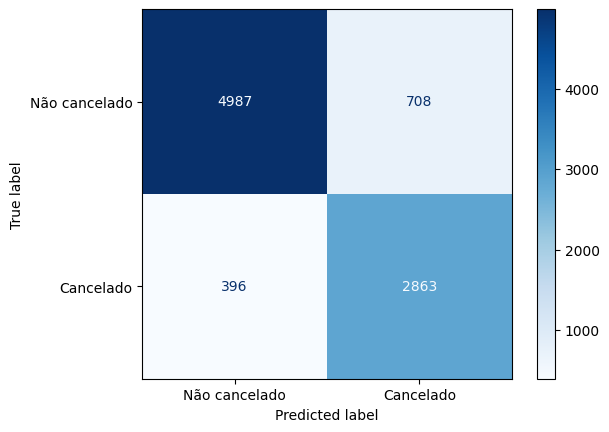

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.50%
Modelo previu não cancelado, e é não cancelado: 83.50%
Modelo previu não cancelado, mas é cancelado: 25.55%
Modelo previu cancelado, e é cancelado: 74.45%


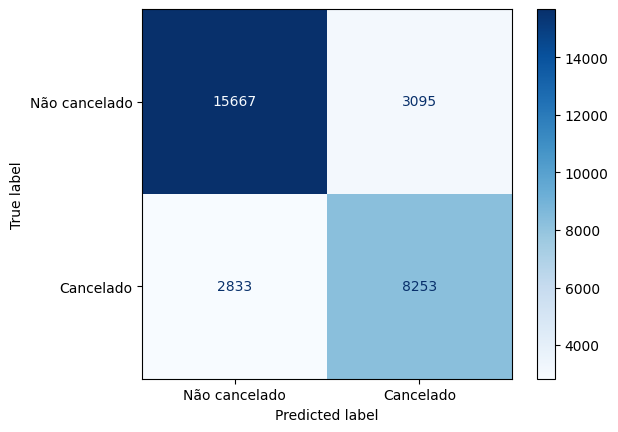

CPU times: user 16.6 s, sys: 15.8 ms, total: 16.6 s
Wall time: 16.7 s


[87.67031494304221,
 80.13937282229965,
 87.56804214223003,
 87.84903344584228,
 83.50389084319369,
 74.44524625653978]

In [30]:
%%time
calculate_model_acc_score(grid_search.best_estimator_, x_train, y_train, x_test, y_test, show_confusion_matrix=True, show_acc=True)

## 6. Conclusão<a name="6"></a>

Na nossa busca pelos melhores parâmetros utilizando grid, não obtivemos resultados melhores, provavelmente pela verificação com Cross Validation, o que indica que os parâmetros {'C': 1, 'gamma': 0.1} devem ser mais robustos.

Neste momento, para simplificar, estamos apenas buscando as melhores acurácias para cancelamentos, então vamos seguir com o melhor modelo que encontramos, com os parâmetros `class_weight='balanced'`, `C=100` e com uma base de treino de mais de 60 mil amostras.

As acurácias encontradas então foram (em parênteses as acurácias do antigo melhor modelo):

- Acurácia na base de treino: 86,84% (81.53%)
    - Modelo previu cancelado, mas é não cancelado: 12.97% (17.47%)
    - Modelo previu não cancelado, e é não cancelado: 87.03% (82.53%)
    - Modelo previu não cancelado, mas é cancelado: 13.50% (20.17%)
    - Modelo previu cancelado, e é cancelado: 86.50% (79.83%)
- Acurácia na base de teste: 82.71% (81.28%)
    - Modelo previu cancelado, mas é não cancelado: 15.92% (17.21%)
    - Modelo previu não cancelado, e é não cancelado: 84.08% (82.79%)
    - Modelo previu não cancelado, mas é cancelado: 19.62% (21.27%)
    - Modelo previu cancelado, e é cancelado: 80.38% (78.73%)

Alguns pontos sobre o modelo SVM, principalmente do SVC utilizado, fornecido pelo scikit-learn, com o kernel RBF (Gaussian Radial Basis Function):
- Cuidado com tamanho de amostras: por ter complexidade quadrática e até cúbica dependente desse valor, quanto maior a amostra, pior para treinar o modelo (demora muito). Em torno de 10 mil amostras o modelo treinou bem rápido, mas com 60 mil algumas operações ficaram extremamente lentas. É interessante iniciar com poucas amostras e ir aumentando aos poucos até o limite aceitável pelo usuário.
- O modelo é relativamente simples de implementar e melhorar, sendo o tempo o maior impeditivo.
- Para "tunar" os parâmetros, pode ser interessante utilizar uma amostra pequena, para posteriormente aplicar em uma amostra maior e obter resultados melhores. Os resultados no nosso exemplo com amostras menores não foi tão inferior quanto a com amostras maiores, mas a diferença foi significativa.
- É muito importante balancear os dados. O modelo apresenta dificuldade quando existem muito mais rótulos de um tipo que de outro. No entanto, o parâmetro `class_weight='balanced'` parece funcionar bem para esse fim.
- É extremamente importante padronizar os dados. O modelo não lida muito bem com dados não padronizados ou normalizados. Utilizar a função `StandardScaler()` é uma boa solução para esse caso.

Vamos finalizar o caderno por aqui, mas no próximos iremos abordar uma "evolução" do nosso primeiro método de árvores de decisão: o Random Forest.

O próximo caderno pode ser acessado aqui: link